In [1]:
# solving Lorenz inverse equation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5125925473549809667
xla_global_id: -1
]


In [4]:
# get the data
def get_traindata():
    data = np.load("Lorenz.npz")
    return data["t"], data["y"]

In [5]:
# define the lorenz PDE output
def lorenz(x, y, z, rho=10, sigma=15, beta=8/3):
    dxdt = rho * (y - x)
    dydt = x * (sigma - z) - y
    dzdt = x * y - beta * z

    return dxdt, dydt, dzdt

In [6]:
# here's a feedforward neural network -> change the architecture when you're ready
# import necessary modules
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dense, Input


class DenseBlock(tf.keras.Model):
    def __init__(self, layers, layer_width, bn=False, name="encoder"):
        """
        Creates a sequence of equal width dense layers
        :param layers: number of dense layer repetitions
        :param layer_width: number of neurons per dense layer
        """
        # supercharge
        super(DenseBlock, self).__init__()

        # operations
        self.dense = self._make_dense(layers, layer_width, bn, name)

    @staticmethod
    def _make_dense(layers, layer_width, bn, name, init="glorot_uniform"):
        input_shape = Input(shape=(1,), name="input")
        x = input_shape

        for i in range(layers):
            x = Dense(
                layer_width,
                activation="tanh",
                kernel_initializer=init,
                name="dense_{}".format(i + 1),
            )(x)
            if bn:
                x = BatchNormalization(name="bn_{}".format(i + 1))(x)

        y1 = Dense(1, kernel_initializer=init, name="y1")(x)
        y2 = Dense(1, kernel_initializer=init, name="y2")(x)
        y3 = Dense(1, kernel_initializer=init, name="y3")(x)

        return tf.keras.Model(inputs=input_shape, outputs=[y1, y2, y3], name=name)

    def call(self, x):
        return self.dense(x)

In [68]:
def get_lorenz():
    # data = get_traindata()

    # initial conditions
    # this is where the system is at at time 0
    x0 = -8
    y0 = 7
    z0 = 27

    # true solutions
    rhogt = 10
    sigmagt = 15
    betagt = 8/3
    

    # we want the PDE to find the solutions of the parameters
    # so it can effectively reproduce the system of x, y, z over time

    dt = 0.01
    num_steps = 1000

    # Need one more for the initial values
    ts = np.empty((num_steps + 1, 1))
    xs = np.empty((num_steps + 1, 1))
    ys = np.empty((num_steps + 1, 1))
    zs = np.empty((num_steps + 1, 1))

    # Set initial values
    ts[0],xs[0], ys[0], zs[0] = (0., -8, 7, 27)

    # ts, xs, ys, zs = [0], [x0], [y0], [z0]

    # stepping through time steps to get PDE solution
    for i in range(num_steps):
        dxdt, dydt, dzdt = lorenz(xs[i], ys[i], zs[i], rhogt, sigmagt, betagt)

        xs[i + 1] = xs[i] + (dxdt * dt)
        ys[i + 1] = ys[i] + (dydt * dt)
        zs[i + 1] = zs[i] + (dzdt * dt)
        ts[i + 1] = ts[i] + dt

        # xs.append(xs[i] + dxdt * dt)
        # ys.append(ys[i] + dydt * dt)
        # zs.append(zs[i] + dzdt * dt)
        # ts.append(ts[i] + dt)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, lw=.75)
    ax.set_xlabel("X Axis", fontsize=16)
    ax.set_ylabel("Y Axis", fontsize=16)
    ax.set_zlabel("Z Axis", fontsize=16)
    ax.set_title("Ground-Truth", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=10,pad=2)
    ax.tick_params(axis='both', which='minor', labelsize=8,pad=2)
    plt.show()

    return ts, xs, ys, zs

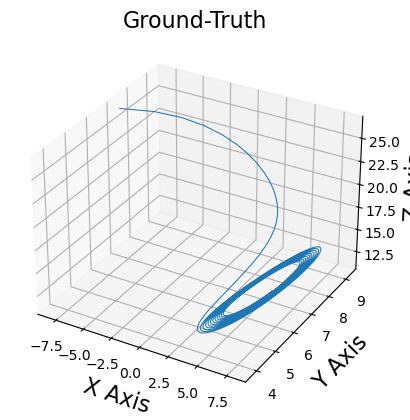

(array([[ 0.  ],
        [ 0.01],
        [ 0.02],
        ...,
        [ 9.98],
        [ 9.99],
        [10.  ]]),
 array([[-8.        ],
        [-6.5       ],
        [-5.061     ],
        ...,
        [ 5.79881067],
        [ 5.87735429],
        [ 5.95743047]]),
 array([[7.        ],
        [7.89      ],
        [8.5079    ],
        ...,
        [6.58424686],
        [6.67811609],
        [6.76996243]]),
 array([[27.        ],
        [25.72      ],
        [24.52128333],
        ...,
        [12.24578524],
        [12.30103898],
        [12.36550782]]))

In [69]:
get_lorenz()

In [70]:
def mse_loss(u_true, y_pred):

    loss_x = tf.reduce_mean(tf.square(y_pred[0] - u_true[0]))
    loss_y = tf.reduce_mean(tf.square(y_pred[1] - u_true[1]))
    loss_z = tf.reduce_mean(tf.square(y_pred[2] - u_true[2]))
    loss_fx = tf.reduce_mean(tf.square(y_pred[3]))
    loss_fy = tf.reduce_mean(tf.square(y_pred[4]))
    loss_fz = tf.reduce_mean(tf.square(y_pred[5]))


    # loss_ic = y_pred[0][0] - u_true[0][0] + y_pred[1][0] - u_true[1][0] + y_pred[2][0] - u_true[2][0]

    # larger weight given to incorrect x, y, and z terms
    # since this is an inverse problem, we add loss due to parameter terms
    return 10*(loss_x+loss_y+loss_z) + loss_fx+loss_fy+loss_fz # + loss_ic
    # return loss_x+loss_y+loss_z # + loss_ic

In [77]:
def train_lorenz(epochs=1000):

    ts, xs, ys, zs = get_lorenz()

    # convert to tf tensors
    ts = tf.convert_to_tensor(ts, dtype=tf.float32)
    xs = tf.convert_to_tensor(xs, dtype=tf.float32)
    ys = tf.convert_to_tensor(ys, dtype=tf.float32)
    zs = tf.convert_to_tensor(zs, dtype=tf.float32)

    # now we are training

    NN = DenseBlock(layers=3, layer_width=32, bn=True)
    
    # optimizer
    optimizer = tf.optimizers.Adam(learning_rate=1e-2)

    # initializing parameters
    rho = tf.Variable(1.0, trainable=True)
    sigma = tf.Variable(1.0, trainable=True)
    beta = tf.Variable(1.0, trainable=True)


    # training loop
    for epoch in range(epochs):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(ts)
            # forward pass
            [x, y, z] = NN(ts)

            # finding the gradient with automatic differentiation
            dxdt = tape.gradient(x, ts)
            dydt = tape.gradient(y, ts)
            dzdt = tape.gradient(z, ts)

            # del tape

            rx = dxdt - rho * (y - x)
            ry = dydt - x * (sigma - z) + y
            rz = dzdt - x * y + beta * z

            y_pred = [x, y, z, rx, ry, rz]

            # y_pred = [x, y, z]

            # calculate loss
            loss = mse_loss(u_true=[xs, ys, zs], y_pred=y_pred)

            # print(loss.numpy().item() / ts.shape[0], rho.numpy().item(), sigma.numpy().item(), beta.numpy().item())

        # tape grads
        # TODO: fix this so it works for tensorflow 2.0

            grads = tape.gradient(loss, [rho, sigma, beta] + NN.trainable_variables)

            # grads = tape.gradient(loss, NN.trainable_variables)
        

        optimizer.apply_gradients(zip(grads, [rho, sigma, beta] + NN.trainable_variables))
        
        # optimizer.apply_gradients(zip(grads, NN.trainable_variables))

        # plot the predicted figure every 100 epochs
        if epoch % 100 == 0:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(x, y, z, lw=.75)
            ax.set_xlabel("X Axis", fontsize=16)
            ax.set_ylabel("Y Axis", fontsize=16)
            ax.set_zlabel("Z Axis", fontsize=16)
            ax.set_title(f"Learned_{epoch}", fontsize=16)
            ax.tick_params(axis='both', which='major', labelsize=10,pad=2)
            ax.tick_params(axis='both', which='minor', labelsize=8,pad=2)
            plt.show()



        # del tape
        # optimizer.minimize(loss=loss, var_list=[rho, sigma, beta, NN.trainable_variables])

    tf.saved_model.save(NN, "lorenz_inverse_0.1")

    # ground truth figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, lw=.75)
    ax.set_xlabel("X Axis", fontsize=16)
    ax.set_ylabel("Y Axis", fontsize=16)
    ax.set_zlabel("Z Axis", fontsize=16)
    ax.set_title("Ground-Truth", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=10,pad=2)
    ax.tick_params(axis='both', which='minor', labelsize=8,pad=2)
    plt.show()

    # learned figure
    fig = plt.figure()

    # predict curve
    output = NN(ts)
    x_pred, y_pred, z_pred = output[0], output[1], output[2]
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x_pred, y_pred, z_pred, lw=.75)
    ax.set_xlabel("X Axis", fontsize=16)
    ax.set_ylabel("Y Axis", fontsize=16)
    ax.set_zlabel("Z Axis", fontsize=16)
    ax.set_title("Learned", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=10,pad=2)
    ax.tick_params(axis='both', which='minor', labelsize=8,pad=2)
    plt.show()

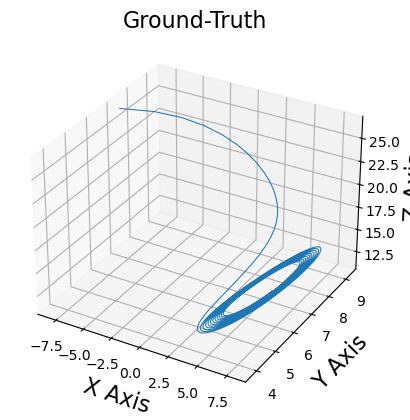

IndexError: list index out of range

In [78]:
train_lorenz(epochs=60000)